## Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

### Load and clean data

In [2]:
# Load file
filename = 'LTMZones1.csv'
f = lambda x: (x.replace(",",".")) 
rawdata = pd.read_csv(filename, sep=';', decimal=',')#converters = {'Latitude (Start)':f, 'Longitude (Start)':f})

/home/peterg/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (3,4,5,6,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Show data
display(rawdata)

,TurID,BilID,PersonID,Latitude (Start),Longitude (Start),Latitude (Slut),Longitude (Slut),Reservationstidspunkt,Start tidspunkt,Slut tidspunkt,Alder,Køn,Batteristatus (start),Batteristatus (slut),Km kørt,FromZoneID,ToZoneID
0,1,WBY1Z21040V307905,32614,55.6703,12.5861,55.653,12.5447,16/08/2017 14:40,16/08/2017 14:34,16/08/2017 14:52,32,M,94,91,5,103142,102851
1,2,WBY1Z21040V308214,44363,55.687,12.586,55.7267,12.5539,16/08/2017 14:42,16/08/2017 14:38,16/08/2017 15:05,25,M,48,42,7,102212,157231
2,3,WBY1Z21070V307929,38610,55.6924,12.5831,55.7757,12.514,31/07/2017 07:28,31/07/2017 07:21,01/08/2017 12:49,21,M,0,0,19,102213,173051
3,4,WBY1Z21040V307869,37425,55.6303,12.6489,55.7069,12.5871,31/07/2017 20:31,31/07/2017 20:31,01/08/2017 09:13,30,M,0,0,18,185203,102341
4,5,WBY1Z21030V307877,24168,55.6936,12.5382,55.6775,12.4892,31/07/2017 20:48,31/07/2017 20:44,01/08/2017 08:52,28,M,0,0,5,102454,102771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117830,120481,WBY1Z21010V307831,45879,"55,645887","12,605008","55,6425","12,60724",09/11/2017 15:47,09/11/2017 15:41,09/11/2017 16:00,26,M,47,39,5,103252,103251
117831,120482,WBY1Z21080V308247,47793,"55,66293","12,5143","55,665967","12,494803",09/11/2017 15:47,09/11/2017 15:45,09/11/2017 16:19,20,M,89,79,6,102724,102732
117832,120483,WBY1Z21070V308045,28924,"55,630252","12,648886","55,699598","12,530801",09/11/2017 15:25,09/11/2017 15:24,09/11/2017 16:21,43,M,43,13,27,185203,102541
117833,120484,WBY1Z21040V307855,49796,"55,68031","12,552588","55,672008","12,495394",09/11/2017 15:25,09/11/2017 15:24,09/11/2017 15:42,19,M,85,76,5,147112,102771


In [4]:
# Extract pickup location (lat/long) and pickup time
X = rawdata[['Start tidspunkt', 'Latitude (Start)', 'Longitude (Start)']]
X = X.rename(columns={'Latitude (Start)':'lat', 'Longitude (Start)':'lon', 'Start tidspunkt':'t'})
print(f'Total number of unfiltered datapoints: {len(X)}')

# Find and remove missing values (denoted by '-')
rm_idx = rawdata[(rawdata['Longitude (Start)'] == '-') | (rawdata['Longitude (Slut)'] == '-')].index
X = X.drop(index=rm_idx)

# Replace commas with decimal points where read_csv failed
def fix(x):
    if type(x) is str:
        x = float(x.replace(',', '.'))
    return x
X.lon = X.lon.apply(lambda x: fix(x))
X.lat = X.lat.apply(lambda x: fix(x))
print(f'Total number of filtered datapoints: {len(X)}')

assert X.lon.dtype == 'float64'
assert X.lat.dtype == 'float64'

# Format columns, sort, reindex
X.t = pd.to_datetime(X.t)
X = X.sort_values(by='t')
X = X.set_index('t')

# Determine grid boundaries
full_data = False
if full_data:
    latMax = X.lat.max() # 56.03
    latMin = X.lat.min() # 55.53
    lonMax = X.lon.max() # 12.68
    lonMin = X.lon.min() # 12.07
else:
    latMax = 55.73
    latMin = 55.62
    lonMax = 12.67
    lonMin = 12.52
    # Remove datapoints outside the boundary
    rm_idx = X[(X.lat > latMax) | (X.lat < latMin) | (X.lon > lonMax) | (X.lon < lonMin)].index
    X = X.drop(index=rm_idx)    
print(f'Total datapoints to be used for modeling: {len(X)}')

# Specify grid size
k = 32

Total number of unfiltered datapoints: 117835
Total number of filtered datapoints: 117833
Total datapoints to be used for modeling: 74588


### Batch data into user-defined hour intervals

In [41]:
# Batch datapoints into two-hour intervals
freq = '180min'
start = X.resample(freq).count().index[0]
end   = X.resample(freq).count().index[-1]
N  = X.resample(freq).count().values[:,0]
Nt = pd.date_range(start=start, end=end, freq=freq)
Nmax = max(N)
T    = len(N)

### Create tensors

In [71]:
# Create X Tensor:
# Format [N, T, Nt, D]
# N: number of sequences (1)
# T: time index, two hour intervals
# N_t: coordinates at time t (lat, lon)
# D: dimension of data (2)

# Group in 2h intervals
grouped = X.resample(freq)
# Allocate tensor
Xt = torch.zeros((1, T, Nmax, 2))
# Fill tensor
for i, (name, group) in enumerate(grouped):
    Xt[0, i, :N[i], :] = torch.from_numpy(group.values)
print(f'Shape of X matrix: {Xt.shape}')

Shape of X matrix: torch.Size([1, 2871, 259, 2])


In [72]:
# Create U Tensor:

# Allocate
U = torch.zeros((1, T, k, k))
for i in range(T-1):
    # Extract current lat/lon
    temp = Xt[:, i, :N[i], :] 
    x = temp.numpy()[:,:,0][0]
    y = temp.numpy()[:,:,1][0]
    # Compute 2d histogram of current values in given grid
    u, r1, r2 = np.histogram2d(x=x, y=y, bins=[k,k], range=[[latMin, latMax], [lonMin, lonMax]])
    # Normalise such that values sum to 1
    if u.sum() > 0:
        u /= u.sum()
    # Fill
    U[:, i+1, :, :] =  torch.from_numpy(u)
print(f'Shape of U matrix: {U.shape}')

Shape of U matrix: torch.Size([1, 2871, 32, 32])


In [73]:
# First U (zeros) is discarded alongside first X
Xt = Xt[:, 1:, :, :]
U  = U[:, 1:, :, :]

In [74]:
lonmean = X.lon.mean()
latmean = X.lat.mean()
lonstd  = X.lon.std()
latstd  = X.lon.std()
for i in range(len(grouped)-1):
    Xt[0, i, :N[i], 0] = (Xt[0, i, :N[i], 0] - torch.ones(Xt[0, i, :N[i], 0].shape)*latmean)/latstd
    Xt[0, i, :N[i], 1] = (Xt[0, i, :N[i], 1] - torch.ones(Xt[0, i, :N[i], 1].shape)*lonmean)/lonstd

### Split into training, test and validation sets

In [79]:
lb = Xt.shape[1]//2
ub = lb + Xt.shape[1]//4
X_train_tensor = Xt[:, :lb,   :, :]
X_test_tensor  = Xt[:, lb:ub, :, :]
X_val_tensor   = Xt[:, ub:,   :, :]
U_train_tensor = U[:, :lb,    :, :]
U_test_tensor  = U[:, lb:ub,  :, :]
U_val_tensor   = U[:, ub:     :, :]
N_t_train      = N[:lb]
N_t_test       = N[lb:ub]
N_t_val        = N[ub:]

### Save Tensors

In [82]:
torch.save(X_train_tensor, './data/X_train_tensor.pt')
torch.save(X_test_tensor, './data/X_test_tensor.pt')
torch.save(X_val_tensor, './data/X_val_tensor.pt')
torch.save(U_train_tensor, './data/U_train_tensor.pt')
torch.save(U_test_tensor, './data/U_test_tensor.pt')
torch.save(U_val_tensor, './data/U_val_tensor.pt')
np.save('./data/N_t_train.npy', N_t_train)
np.save('./data/N_t_test.npy', N_t_test)
np.save('./data/N_t_val.npy', N_t_val)

In [80]:
Usum = np.zeros((k,k))
for i in range(T-1):
    Usum += U[:,i,:,:].squeeze().numpy()
Usum *= 10    

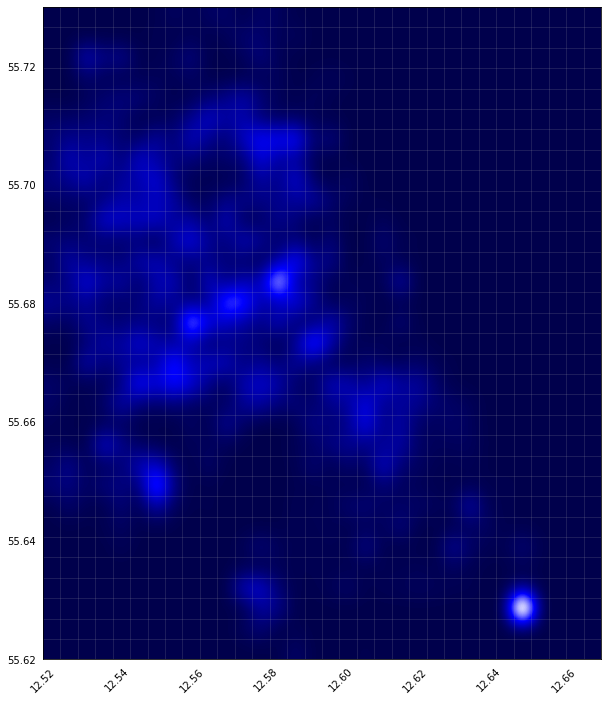

In [81]:
fig, ax = plt.subplots(figsize=(10,12))

ax.imshow(np.flipud(Usum), interpolation='bicubic',cmap='seismic', aspect='auto', extent=(lonMin, lonMax, latMin, latMax))
ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=True, right=False, left=False, labelleft=True)
#plt.xticks(r2,rotation='vertical')
#plt.yticks(r1)
ax.set_xticks(r2, minor=True)
ax.set_yticks(r1, minor=True)
ax.xaxis.grid(True, which='minor', alpha=0.2)
ax.yaxis.grid(True, which='minor', alpha=0.2)
ax.tick_params(axis='x', labelrotation= 45)
#ax.set_xticklabels(r2)

plt.show()

In [346]:
import numpy as np
import pyro
import torch
from torch import nn
import pyro.distributions as dist

In [347]:
class SRNN(nn.Module):
    """
    Basic model of SRNN with GMM emission function 
    """
    def __init__(self, input_dim=2, u_dim=32, z_dim=128, lstm_dim=128, nn_dim=128, k=64):
        super(model, self).__init__()
        
        # Initialisations
        self.h = nn.LSTM(input_size=u_dim, hidden_size=lstm_dim, batch_first=True, num_layers=1, bidrectional=False)
        self.FeatureExtractor  = FeatureExtractor(k=k, u_dim=u_dim)
       
        self.h_0 = nn.Parameter(torch.zeros(lstm_dim))
        self.z_0 = nn.Parameter(torch.zeros(z_dim))
    
        self.input_dim=input_dim
        self.u_dim = u_dim
        self.z_dim = z_dim
        self.lstm_dim = lstm_dim
        self.nn_dim = nn_dim
    
    
    def model(self, X=None, U=None, mask=None, batch_size=1):
        
        # Sequence number
        N = len(U)
        D = self.input_dim
        b = min(N, batch_size)
        T_max = U.size(1)
        
        # Extract features of U to use in LSTM 
        X_features = torch.zeros((N, 1))
        for n in range(N):
            X_features[n] = self.FeatureExtractor(U[n]).view(1, 1, 32)

            
        pyro.module("SRNN", self)
        
        
        h_prev = self.h_0.expand(b, self.h_0.size(0)).view(1, b, -1).contiguous()
        z_prev = self.z_0.expand(b, self.z_0.size(0)).contiguous()
        hidden_prev = (h_prev, z_prev)
        
        # Allocate samples
        x_samples = torch.zeros((b, T_max, max(mask), D))
        
        
        with pyro.plate("data", N):
            for t in pyro.markov(range(2, T_max+1)):
                # Inpute for LSTM
                lstm_input = X_features[:, t-2].view(b, 1, self.u_dim)
                # Feed through LSTM
                _, hidden_prev = self.lstm(lstm_input, hidden_prev)
                
                # Compute parameters for z distribution
                z_loc, z_scale = self.LatentInput(z_prev, hidden_prev[0].view(b, self.lstm_dim))
                # Sample z
                z_t = pyro.sample("z_%d"%t, dist.Normal(z_loc.view(b, 2, self.z_dim), z_scale.view(b, 1, self.z_dim)).to_event(1))
                
                # Compute parameters for GMM (similar to the above)
                # Compute sample as this mix
                
                #
        
        pass
    

    
class FeatureExtractor(nn.Module):
    """
    Extract features from input and returns input for LSTM cell
    """
    def __init__(self, k=64, u_dim=32):
        super(FeatureExtractor, self).__init__()
        self.input_to_hidden  = nn.Linear(k*k, 128)
        self.hidden_to_hidden = nn.Linear(128, 128)
        self.hidden_to_output = nn.Linear(128, u_dim)
        self.reu = nn.ReLU()
        self.k = k
        
    def forward(self, u):
        u = u.view(-1, self.k*self.k)
        hidden = self.relu(self.input_to_hidden(u))
        hidden = self.relu(self.hidden_to_hidden(hidden))
        u = self.hidden_to_output(hidden)
        return u

class LatentInput(nn.Module):
    """
    Class to compute parameters for diagonal Gaussian distribution 
    over stochastic hidden state z
    """
    def __init__(self, z_dim=128, lstm_dim=128, hidden_dim=128):
        super(LatentInput, self).__init__()
        
        # Define NN to compute parameters for p(z|ht, zt-1)
        self.input_to_hidden = nn.Linear(lstm_dim+z_dim, hidden_dim)
        self.hidden_to_loc   = nn.Linear(hidden_dim, z_dim)
        self.hidden_to_scale = nn.Linear(hidden_dim, z_dim)
        self.relu = nn.ReLU()
        
    def forward(self, z_t_1, h_t):
        """
        Forward pass of NN to determine scale and location parameter for p(z)
        """
        hidden = self.relu(self.input_to_hidden(torch.cat((z_t_1, h_t)), dim=1))
        loc    = self.hidden_to_loc(hidden)
        scale  = self.hidden_to_scale(hidden)
        
        return loc, scale
    
class GMMInput(nn.Module):
    """
    Extract features from z_t and h_t and compute parameters for Gaussian mixes
    """
    def __init__(self, z_dim=128, lstm_dim=128, hidden_dim=128, k=64):
        super(GMMInput, self).__init__()
        self.input_dim  = z_dim+lstm_dim
        self.hidden_dim = hidden_dim
        self.k = k
        self.input_to_hidden = nn.Linear(self.input_dim, self.hidden_dim)
        self.hidden_to_loc   = nn.Linear(self.hidden_dim, self.k)
        self.hidden_to_scale = nn.Linear(self.hidden_dim, self.k)
        self.hidden_to_mixes = nn.Linear(self.hidden_dim, self.k)
        self.relu = nn.ReLU()

        
    def forward(self, z_t, h_t):
        hidden = self.relu(self.input_to_hidden(torch.cat((z_t, h_t)), dim=1))
        loc    = self.hidden_to_loc(hidden)
        scale  = self.hidden_to_scale(hidden)
        mixes  = self.hidden_to_mixes(hidden)
        return loc, scale, mixes
    